In [49]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [51]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [52]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [53]:
tf.keras.backend.clear_session()

In [54]:
subject = 'Paraíba - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [55]:
data = pd.read_csv('2003_mo_model_input_PB.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Paraíba - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,38.426,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,31.672,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,28.775,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,28.571,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,31.613,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


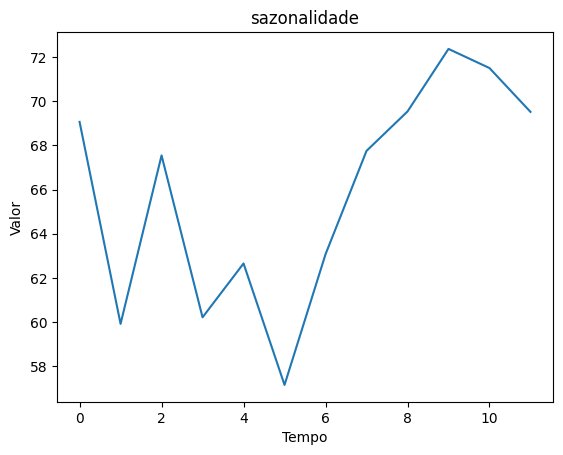

,sazonalidade
sazonalidade,
0,69.069500
1,59.915333
2,67.549780
3,60.211663
4,62.652825
5,57.147556
6,63.070021
7,67.754987
8,69.541524


In [56]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [57]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraíba - Consumo de Cimento (t)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,69.069500,38.426
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,59.915333,31.672
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,67.549780,28.775
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,60.211663,28.571
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,62.652825,31.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.652825,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.147556,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.070021,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.754987,NaN


In [58]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Paraíba - Consumo de Cimento (t), Length: 249, dtype: float64

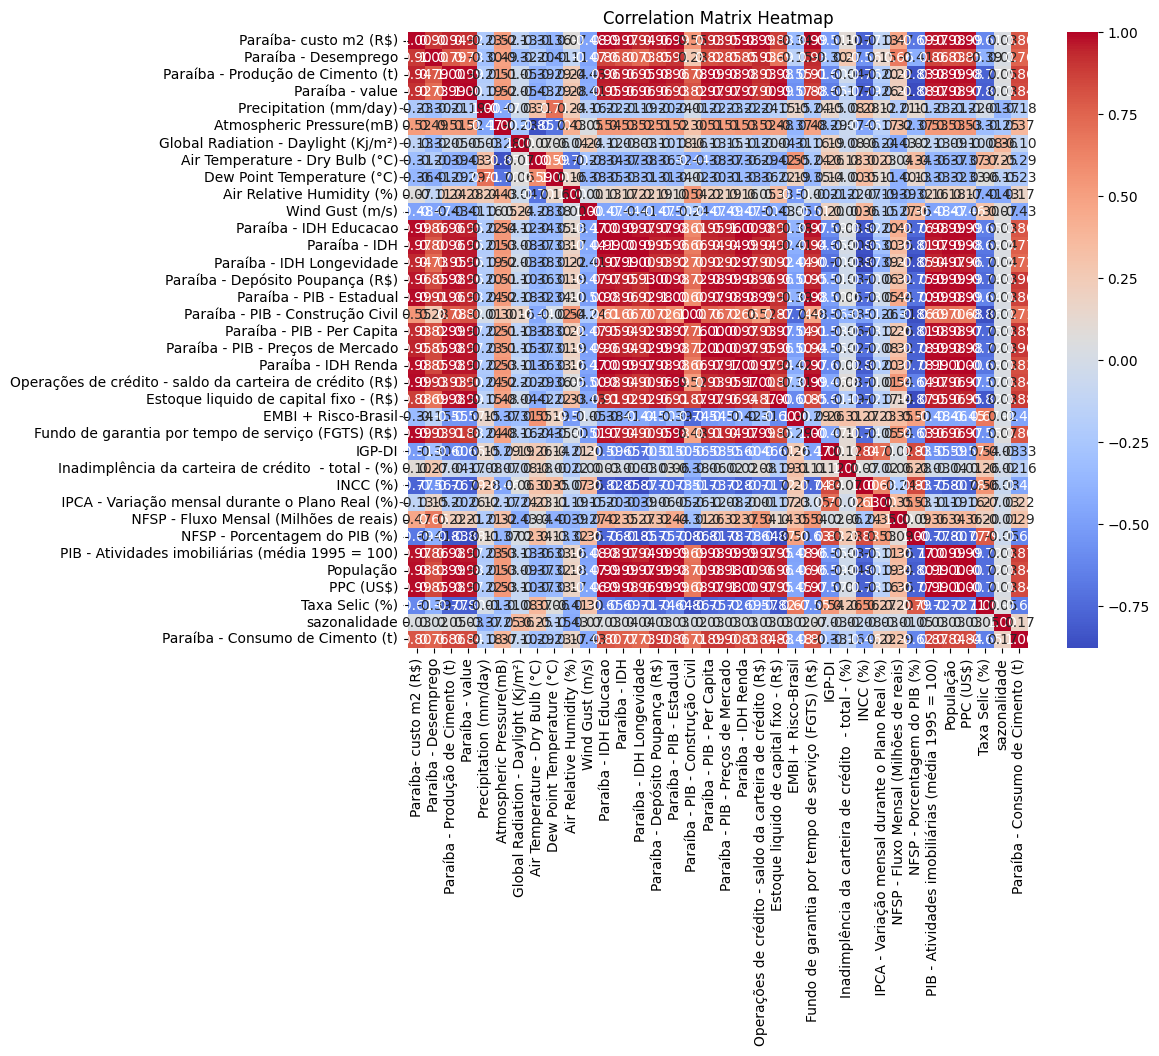

In [59]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [61]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Paraíba- custo m2 (R$),1.232258e+06
1,Paraíba - Desemprego,2.448599e+03
2,Paraíba - Produção de Cimento (t),9.905629e+04
3,Paraíba - value,2.605606e+05
4,Precipitation (mm/day),2.658664e+02
5,Atmospheric Pressure(mB),5.080893e+07
6,Global Radiation - Daylight (Kj/m²),4.933966e+02
7,Air Temperature - Dry Bulb (°C),2.341024e+06
8,Dew Point Temperature (°C),1.613625e+06
9,Air Relative Humidity (%),1.547983e+06


In [62]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 3


,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,0.600949,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,69.069500
1,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,0.601441,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,59.915333
2,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,0.601934,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,67.549780
3,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,0.602426,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,60.211663
4,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,0.602918,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,62.652825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,23522.556146,11.099253,198.799183,0.560149,1.035964,949.648829,1551.551916,21.379875,18.210223,83.544388,4.426565,0.654788,4.922937e+06,3.602670e+07,1.708751e+06,7.486100,0.661177,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,67.754987
176,23608.322289,11.101732,199.062337,0.560154,0.878047,949.361357,1381.278675,22.036723,18.300223,80.918322,4.436958,0.654672,4.938355e+06,3.601732e+07,1.708600e+06,7.485481,0.661164,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,69.541524
177,23694.182496,11.104211,200.716313,0.560115,0.671815,948.924949,1308.823543,22.791679,18.542603,78.562196,4.393780,0.654555,4.953773e+06,3.600795e+07,1.708449e+06,7.484863,0.661151,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,72.376473
178,23774.255502,11.106690,202.015097,0.560068,0.986837,948.490685,1329.870189,23.501344,18.828130,76.622119,4.177290,0.654438,4.969191e+06,3.599858e+07,1.708298e+06,7.484244,0.661138,3.083099e+06,7.776397e+06,263.741041,1.07

In [63]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.734124,-2.155869,-2.356232,-0.019748,-0.208618,0.866348,-0.121525,0.029513,0.146789,1.375985,-1.865983,-1.671003,-1.653660,-2.419929,-2.189838,-1.940696,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,0.665215
1,-0.738656,-2.207659,-2.324477,-0.019448,-0.207540,0.866348,-0.121996,0.029735,0.147690,1.370388,-1.840822,-1.660326,-1.635121,-2.373764,-2.154148,-1.913682,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.232202
2,-0.743187,-2.174157,-2.292026,-0.019273,-0.206911,0.866348,-0.122271,0.029864,0.148215,1.367123,-1.815662,-1.649650,-1.616582,-2.327599,-2.118457,-1.886668,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.350217
3,-0.747718,-2.135843,-2.258905,-0.019254,-0.206843,0.866348,-0.122300,0.029877,0.148271,1.366773,-1.790502,-1.638973,-1.598043,-2.281434,-2.082767,-1.859653,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-1.170780
4,-0.752250,-2.044149,-2.225141,0.087639,-0.309666,0.831112,0.011977,0.066056,0.016999,1.310436,-1.765342,-1.628296,-1.579504,-2.235269,-2.047076,-1.832639,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.664792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.345877,1.287639,0.972246,-0.763668,1.367872,2.095337,-1.371403,-1.835704,0.007374,0.106769,1.479317,1.199449,1.265450,-0.208279,0.875578,1.363335,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,0.392751
176,1.347730,1.298984,0.972293,-1.524517,1.069514,1.088420,-0.636835,-1.691163,-0.792635,0.132353,1.473010,1.214276,1.260776,-0.212596,0.865848,1.362615,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,0.763053
177,1.349582,1.370290,0.971950,-2.518148,0.616580,0.659954,0.207447,-1.301895,-1.510408,0.026059,1.466702,1.229104,1.256102,-0.216913,0.856119,1.361896,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.350663
178,1.351435,1.426284,0.971530,-1.000365,0.165871,0.784414,1.001081,-0.843332,-2.101436,-0.506881,1.460395,1.243932,1.251428,-0.221230,0.846389,1.361177,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,1.170896


In [64]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.734124,-2.155869,-2.356232,-0.019748,-0.208618,0.866348,-0.121525,0.029513,0.146789,1.375985,-1.865983,-1.671003,-1.653660,-2.419929,-2.189838,-1.940696,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,0.665215
1,-0.738656,-2.207659,-2.324477,-0.019448,-0.207540,0.866348,-0.121996,0.029735,0.147690,1.370388,-1.840822,-1.660326,-1.635121,-2.373764,-2.154148,-1.913682,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.232202
2,-0.743187,-2.174157,-2.292026,-0.019273,-0.206911,0.866348,-0.122271,0.029864,0.148215,1.367123,-1.815662,-1.649650,-1.616582,-2.327599,-2.118457,-1.886668,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.350217
3,-0.747718,-2.135843,-2.258905,-0.019254,-0.206843,0.866348,-0.122300,0.029877,0.148271,1.366773,-1.790502,-1.638973,-1.598043,-2.281434,-2.082767,-1.859653,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-1.170780
4,-0.752250,-2.044149,-2.225141,0.087639,-0.309666,0.831112,0.011977,0.066056,0.016999,1.310436,-1.765342,-1.628296,-1.579504,-2.235269,-2.047076,-1.832639,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.664792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.371965,0.947670,0.992970,-1.767772,1.443576,-0.260276,-0.412038,-2.248881,-1.386909,0.465600,1.526090,1.019835,1.289972,-0.146262,0.949340,1.400238,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,0.392751
164,1.364154,0.968279,0.992955,-0.753679,0.913281,-0.120142,-0.031169,-2.127512,-1.711750,0.511065,1.525566,1.034999,1.291611,-0.152621,0.948209,1.393865,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,0.763053
165,1.356343,0.976191,0.992207,-0.584068,0.357067,-0.050408,0.291184,-1.842127,-1.866889,0.389893,1.525042,1.050163,1.293251,-0.158981,0.947078,1.387491,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.350663
166,1.348531,0.994579,0.991355,-0.228746,-0.026967,-0.017909,0.562466,-1.414810,-1.842983,0.065240,1.524518,1.065327,1.294890,-0.165341,0.945947,1.381117,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,1.170896


In [65]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
163    64.217
164    57.591
165    64.307
166    61.971
167    57.480
Name: Paraíba - Consumo de Cimento (t), Length: 168, dtype: float64

In [66]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
168,1.332909,0.985979,0.985996,-0.176756,-0.443835,-0.106100,0.743160,-0.284382,-1.159359,-0.678321,1.523470,1.095654,1.298169,-0.178061,0.943685,1.368370,1.376932,0.705491,0.146258,1.774331,-1.414596,1.544952,-1.619756,-1.269571,0.705135,-0.643748,1.133345,1.287235,1.337633,-0.848841,0.665215
169,1.334762,0.970000,0.982544,0.813201,-0.411856,-0.347032,0.636437,0.090583,-0.721119,-1.112595,1.517162,1.110482,1.293495,-0.182378,0.933955,1.367650,1.372955,0.691232,0.069548,1.603011,-1.326123,1.687834,-1.703430,-1.318025,1.050348,-0.639696,1.154937,1.298856,1.349730,-0.710205,-1.232202
170,1.336614,0.973948,0.979302,0.890326,-0.109958,-0.787044,0.241711,0.227241,-0.140097,-1.269099,1.510855,1.125310,1.288821,-0.186695,0.924226,1.366931,1.369449,0.676973,-0.001029,1.566915,-1.203988,1.921399,-1.791187,-1.274124,0.891008,-0.633632,1.176530,1.310477,1.361535,-0.663329,0.350217
171,1.338467,0.958672,0.976669,0.593792,0.557920,-1.004632,-0.445943,-0.196321,0.331141,-0.812882,1.504547,1.140138,1.284147,-0.191012,0.914496,1.366212,1.367904,0.662714,-0.050763,1.509198,-1.033667,1.919191,-1.781750,-1.249228,0.718432,-0.626158,1.198123,1.322098,1.373539,-0.742310,-1.170780
172,1.340319,1.024783,0.974838,0.622388,1.138888,0.453078,-1.093801,-0.717461,0.661514,-0.677002,1.498240,1.154965,1.279472,-0.195328,0.904766,1.365493,1.363452,0.648455,-0.088103,1.510496,-0.794607,1.810466,-1.799478,-1.298144,0.870539,-0.617303,1.214047,1.333718,1.385370,-1.220021,-0.664792
173,1.342172,1.099522,0.974176,-0.163874,1.666591,1.181732,-1.591385,-1.379958,0.681265,-0.070399,1.491932,1.169793,1.274798,-0.199645,0.895037,1.364773,1.359511,0.634197,-0.122336,1.513850,-0.626344,1.568703,-1.782843,-1.416414,0.707986,-0.607822,1.229972,1.345339,1.397504,0.082610,-1.805889
174,1.344024,1.185997,0.973611,-0.500866,1.793183,1.350639,-1.744600,-1.786601,0.507559,0.386313,1.485625,1.184621,1.270124,-0.203962,0.885307,1.364054,1.352561,0.619938,-0.149882,1.502535,-0.480760,1.414649,-1.870854,-1.358337,0.499926,-0.597435,1.245897,1.356960,1.409256,-1.207352,-0.578318
175,1.345877,1.287639,0.972246,-0.763668,1.367872,2.095337,-1.371403,-1.835704,0.007374,0.106769,1.479317,1.199449,1.265450,-0.208279,0.875578,1.363335,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,0.392751
176,1.347730,1.298984,0.972293,-1.524517,1.069514,1.088420,-0.636835,-1.691163,-0.792635,0.132353,1.473010,1.214276,1.260776,-0.212596,0.865848,1.362615,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,0.763053
177,1.349582,1.370290,0.971950,-2.518148,0.616580,0.659954,0.207447,-1.301895,-1.510408,0.026059,1.466702,1.229104,1.256102,-0.216913,0.856119,1.361896,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.350663


In [67]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    68.053
169    55.231
170    53.723
171    57.457
172    62.755
173    48.148
174    62.190
175    62.219
176    61.329
177    81.988
178    79.341
179    76.646
Name: Paraíba - Consumo de Cimento (t), dtype: float64

In [68]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [69]:
def get_a_good_seed(train_input, train_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = neural_network_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")

    return winner_seed

In [70]:
winner_seed = get_a_good_seed(train_input, train_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2967994307, 1408226729, 1311409298, 2226188193, 1434529298, 1361637314, 1933219342, 2444158655, 422813040, 1377731720]


Step: 0 ___________________________________________
val_loss: 33.40071487426758
winner_seed: 2967994307


Step: 1 ___________________________________________
val_loss: 36.369476318359375


Step: 2 ___________________________________________
val_loss: 34.18802261352539


Step: 3 ___________________________________________
val_loss: 27.69022560119629
winner_seed: 2226188193


Step: 4 ___________________________________________
val_loss: 36.43366241455078


Step: 5 ___________________________________________
val_loss: 97.96488189697266


Step: 6 ___________________________________________
val_loss: 27.594879150390625
winner_seed: 1933219342


Step: 7 ___________________________________________
val_loss: 29.008079528808594


Step: 8 ___________________________________________
val_loss: 29.67759132385254


Step: 9 ___________________________________________
val_loss: 42.

In [71]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 0s 23ms/step - loss: 4436.5737 - val_loss: 1014.0096
Epoch 2/10000
5/5 [==============================] - 0s 4ms/step - loss: 3850.3149 - val_loss: 275.7758
Epoch 3/10000
5/5 [==============================] - 0s 4ms/step - loss: 3025.2930 - val_loss: 979.0220
Epoch 4/10000
5/5 [==============================] - 0s 4ms/step - loss: 2200.1345 - val_loss: 33.9728
Epoch 5/10000
5/5 [==============================] - 0s 4ms/step - loss: 1573.5942 - val_loss: 2582.6057
Epoch 6/10000
5/5 [==============================] - 0s 4ms/step - loss: 867.1606 - val_loss: 438.6477
Epoch 7/10000
5/5 [==============================] - 0s 4ms/step - loss: 251.2978 - val_loss: 68.5252
Epoch 8/10000
5/5 [==============================] - 0s 4ms/step - loss: 211.3985 - val_loss: 49.0650
Epoch 9/10000
5/5 [==============================] - 0s 4ms/step - loss: 167.2873 - val_loss: 80.0493
Epoch 10/10000
5/5 [==============================] - 0s 4ms/step - l

5/5 [==============================] - 0s 4ms/step - loss: 23.8346 - val_loss: 614.7155
Epoch 81/10000
5/5 [==============================] - 0s 4ms/step - loss: 24.8299 - val_loss: 571.6050
Epoch 82/10000
5/5 [==============================] - 0s 4ms/step - loss: 24.7814 - val_loss: 603.5837
Epoch 83/10000
5/5 [==============================] - 0s 4ms/step - loss: 27.1663 - val_loss: 531.0916
Epoch 84/10000
5/5 [==============================] - 0s 4ms/step - loss: 24.8016 - val_loss: 607.4512
Epoch 85/10000
5/5 [==============================] - 0s 4ms/step - loss: 24.1756 - val_loss: 499.5924
Epoch 86/10000
5/5 [==============================] - 0s 4ms/step - loss: 25.0359 - val_loss: 693.9289
Epoch 87/10000
5/5 [==============================] - 0s 4ms/step - loss: 25.4668 - val_loss: 672.8915
Epoch 88/10000
5/5 [==============================] - 0s 4ms/step - loss: 24.0327 - val_loss: 839.7547
Epoch 89/10000
5/5 [==============================] - 0s 4ms/step - loss: 26.4124 - val_

5/5 [==============================] - 0s 4ms/step - loss: 22.5023 - val_loss: 535.4980
Epoch 160/10000
5/5 [==============================] - 0s 4ms/step - loss: 21.8794 - val_loss: 538.6831
Epoch 161/10000
5/5 [==============================] - 0s 4ms/step - loss: 25.3724 - val_loss: 471.5861
Epoch 162/10000
5/5 [==============================] - 0s 4ms/step - loss: 23.2369 - val_loss: 381.3678
Epoch 163/10000
5/5 [==============================] - 0s 4ms/step - loss: 23.3331 - val_loss: 420.0598
Epoch 164/10000
5/5 [==============================] - 0s 4ms/step - loss: 22.3412 - val_loss: 455.0440
Epoch 165/10000
5/5 [==============================] - 0s 5ms/step - loss: 21.8763 - val_loss: 426.4219
Epoch 166/10000
5/5 [==============================] - 0s 4ms/step - loss: 22.8433 - val_loss: 468.4164
Epoch 167/10000
5/5 [==============================] - 0s 4ms/step - loss: 22.4426 - val_loss: 446.3716
Epoch 168/10000
5/5 [==============================] - 0s 4ms/step - loss: 20.60

Epoch 238/10000
5/5 [==============================] - 0s 4ms/step - loss: 19.2348 - val_loss: 718.3342
Epoch 239/10000
5/5 [==============================] - 0s 4ms/step - loss: 18.7592 - val_loss: 766.4084
Epoch 240/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.7643 - val_loss: 686.5472
Epoch 241/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.0673 - val_loss: 738.6789
Epoch 242/10000
5/5 [==============================] - 0s 4ms/step - loss: 19.6969 - val_loss: 849.7727
Epoch 243/10000
5/5 [==============================] - 0s 4ms/step - loss: 19.8458 - val_loss: 722.0039
Epoch 244/10000
5/5 [==============================] - 0s 4ms/step - loss: 19.7831 - val_loss: 768.1310
Epoch 245/10000
5/5 [==============================] - 0s 4ms/step - loss: 18.7198 - val_loss: 801.2912
Epoch 246/10000
5/5 [==============================] - 0s 4ms/step - loss: 16.4710 - val_loss: 749.6870
Epoch 247/10000
5/5 [==============================] - 0s 4ms/st

Epoch 317/10000
5/5 [==============================] - 0s 4ms/step - loss: 16.6652 - val_loss: 745.4230
Epoch 318/10000
5/5 [==============================] - 0s 4ms/step - loss: 16.1123 - val_loss: 678.3987
Epoch 319/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.2064 - val_loss: 625.0432
Epoch 320/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.4848 - val_loss: 679.0428
Epoch 321/10000
5/5 [==============================] - 0s 4ms/step - loss: 15.8060 - val_loss: 616.3176
Epoch 322/10000
5/5 [==============================] - 0s 4ms/step - loss: 16.4588 - val_loss: 676.2136
Epoch 323/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.3013 - val_loss: 627.9913
Epoch 324/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.4042 - val_loss: 686.1633
Epoch 325/10000
5/5 [==============================] - 0s 4ms/step - loss: 16.2278 - val_loss: 664.0149
Epoch 326/10000
5/5 [==============================] - 0s 4ms/st

Epoch 396/10000
5/5 [==============================] - 0s 4ms/step - loss: 15.3689 - val_loss: 678.3289
Epoch 397/10000
5/5 [==============================] - 0s 4ms/step - loss: 14.0117 - val_loss: 742.3157
Epoch 398/10000
5/5 [==============================] - 0s 4ms/step - loss: 16.6757 - val_loss: 700.4359
Epoch 399/10000
5/5 [==============================] - 0s 4ms/step - loss: 14.1820 - val_loss: 681.9442
Epoch 400/10000
5/5 [==============================] - 0s 4ms/step - loss: 13.3134 - val_loss: 618.5997
Epoch 401/10000
5/5 [==============================] - 0s 4ms/step - loss: 13.4398 - val_loss: 701.5174
Epoch 402/10000
5/5 [==============================] - 0s 4ms/step - loss: 15.4430 - val_loss: 842.8723
Epoch 403/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.4788 - val_loss: 798.5076
Epoch 404/10000
5/5 [==============================] - 0s 4ms/step - loss: 17.1716 - val_loss: 774.2854
Epoch 405/10000
5/5 [==============================] - 0s 4ms/st

Epoch 475/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.7775 - val_loss: 614.6383
Epoch 476/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.7849 - val_loss: 620.6934
Epoch 477/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.1866 - val_loss: 660.4357
Epoch 478/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.5432 - val_loss: 623.2971
Epoch 479/10000
5/5 [==============================] - 0s 4ms/step - loss: 13.0881 - val_loss: 544.8854
Epoch 480/10000
5/5 [==============================] - 0s 4ms/step - loss: 15.5955 - val_loss: 587.7204
Epoch 481/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.6546 - val_loss: 569.3293
Epoch 482/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.8078 - val_loss: 549.7617
Epoch 483/10000
5/5 [==============================] - 0s 4ms/step - loss: 14.2405 - val_loss: 655.3162
Epoch 484/10000
5/5 [==============================] - 0s 4ms/st

Epoch 554/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.6151 - val_loss: 511.7410
Epoch 555/10000
5/5 [==============================] - 0s 4ms/step - loss: 13.6364 - val_loss: 515.8726
Epoch 556/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.1825 - val_loss: 472.4468
Epoch 557/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.3725 - val_loss: 563.1808
Epoch 558/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.3712 - val_loss: 527.2989
Epoch 559/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.5342 - val_loss: 559.6245
Epoch 560/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.9792 - val_loss: 428.0602
Epoch 561/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.0142 - val_loss: 520.3375
Epoch 562/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.3034 - val_loss: 502.3168
Epoch 563/10000
5/5 [==============================] - 0s 4ms/st

Epoch 633/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.9631 - val_loss: 562.1638
Epoch 634/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.8866 - val_loss: 484.1471
Epoch 635/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.4944 - val_loss: 400.8062
Epoch 636/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.0749 - val_loss: 424.6774
Epoch 637/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.8432 - val_loss: 414.8192
Epoch 638/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.7803 - val_loss: 477.0953
Epoch 639/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.4367 - val_loss: 444.5567
Epoch 640/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.5516 - val_loss: 463.3067
Epoch 641/10000
5/5 [==============================] - 0s 4ms/step - loss: 11.3471 - val_loss: 426.0121
Epoch 642/10000
5/5 [==============================] - 0s 4ms/st

Epoch 712/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.1810 - val_loss: 340.0476
Epoch 713/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.3956 - val_loss: 315.7484
Epoch 714/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.5646 - val_loss: 331.5655
Epoch 715/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.7625 - val_loss: 324.3023
Epoch 716/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.1426 - val_loss: 336.8446
Epoch 717/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.2717 - val_loss: 336.9154
Epoch 718/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.4791 - val_loss: 374.5265
Epoch 719/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.0539 - val_loss: 356.2756
Epoch 720/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.5677 - val_loss: 294.5692
Epoch 721/10000
5/5 [==============================] - 0s 4ms/ste

5/5 [==============================] - 0s 4ms/step - loss: 9.4961 - val_loss: 204.3035
Epoch 792/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.5299 - val_loss: 159.9846
Epoch 793/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.1751 - val_loss: 160.3506
Epoch 794/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.4313 - val_loss: 186.0396
Epoch 795/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.7502 - val_loss: 224.3795
Epoch 796/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.3568 - val_loss: 214.5273
Epoch 797/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.4040 - val_loss: 197.1213
Epoch 798/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.7644 - val_loss: 183.0353
Epoch 799/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.4371 - val_loss: 183.0893
Epoch 800/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.6900 - val

5/5 [==============================] - 0s 4ms/step - loss: 8.7309 - val_loss: 235.1426
Epoch 871/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.9545 - val_loss: 233.5280
Epoch 872/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.3254 - val_loss: 213.7850
Epoch 873/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.1745 - val_loss: 192.1097
Epoch 874/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.8303 - val_loss: 220.9356
Epoch 875/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.9910 - val_loss: 205.4664
Epoch 876/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.9739 - val_loss: 215.0597
Epoch 877/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.7490 - val_loss: 195.8505
Epoch 878/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.6553 - val_loss: 249.1323
Epoch 879/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.2236 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 9.0421 - val_loss: 120.3190
Epoch 950/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.2871 - val_loss: 127.4574
Epoch 951/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.1121 - val_loss: 139.5211
Epoch 952/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.6576 - val_loss: 141.6205
Epoch 953/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.4739 - val_loss: 137.9052
Epoch 954/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.7420 - val_loss: 150.2254
Epoch 955/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.6133 - val_loss: 180.6725
Epoch 956/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.7790 - val_loss: 130.4074
Epoch 957/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.2310 - val_loss: 180.1235
Epoch 958/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.6724 - val_l

Epoch 1029/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.8198 - val_loss: 94.3560
Epoch 1030/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.1173 - val_loss: 116.6131
Epoch 1031/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.9632 - val_loss: 99.0744
Epoch 1032/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.9651 - val_loss: 134.6241
Epoch 1033/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.8560 - val_loss: 114.6325
Epoch 1034/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.7381 - val_loss: 112.5919
Epoch 1035/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.4176 - val_loss: 124.5701
Epoch 1036/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.7562 - val_loss: 122.4686
Epoch 1037/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.6007 - val_loss: 103.7605
Epoch 1038/10000
5/5 [==============================] - 0s 4ms/st

5/5 [==============================] - 0s 4ms/step - loss: 8.2539 - val_loss: 70.2884
Epoch 1109/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.9874 - val_loss: 88.2319
Epoch 1110/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.8332 - val_loss: 72.6600
Epoch 1111/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.5761 - val_loss: 76.5106
Epoch 1112/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.7890 - val_loss: 85.3600
Epoch 1113/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.8825 - val_loss: 75.5883
Epoch 1114/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.0794 - val_loss: 64.1859
Epoch 1115/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.3933 - val_loss: 73.5528
Epoch 1116/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.2450 - val_loss: 72.7412
Epoch 1117/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.6889 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 7.7768 - val_loss: 44.2966
Epoch 1188/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.1973 - val_loss: 45.1586
Epoch 1189/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.9240 - val_loss: 47.4128
Epoch 1190/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.1342 - val_loss: 58.7215
Epoch 1191/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.2854 - val_loss: 48.4211
Epoch 1192/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.1944 - val_loss: 52.9566
Epoch 1193/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.4656 - val_loss: 49.7484
Epoch 1194/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.0278 - val_loss: 46.5270
Epoch 1195/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.3022 - val_loss: 49.2899
Epoch 1196/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.3926 - val

5/5 [==============================] - 0s 4ms/step - loss: 7.0711 - val_loss: 40.4861
Epoch 1267/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.4316 - val_loss: 41.6146
Epoch 1268/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.7864 - val_loss: 44.9619
Epoch 1269/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.9138 - val_loss: 48.1272
Epoch 1270/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.8182 - val_loss: 43.0823
Epoch 1271/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.9027 - val_loss: 51.7730
Epoch 1272/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.5460 - val_loss: 44.0768
Epoch 1273/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.7482 - val_loss: 37.2851
Epoch 1274/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.1295 - val_loss: 41.6268
Epoch 1275/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.0181 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 6.7865 - val_loss: 32.0876
Epoch 1346/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.4539 - val_loss: 34.0001
Epoch 1347/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.6549 - val_loss: 33.1252
Epoch 1348/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.7639 - val_loss: 32.5498
Epoch 1349/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.8372 - val_loss: 35.2338
Epoch 1350/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.2089 - val_loss: 32.9635
Epoch 1351/10000
5/5 [==============================] - 0s 4ms/step - loss: 12.7095 - val_loss: 33.0342
Epoch 1352/10000
5/5 [==============================] - 0s 4ms/step - loss: 10.3211 - val_loss: 40.3785
Epoch 1353/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.2411 - val_loss: 36.5203
Epoch 1354/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.8150 - val

5/5 [==============================] - 0s 4ms/step - loss: 6.8104 - val_loss: 32.7791
Epoch 1425/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.0241 - val_loss: 29.9956
Epoch 1426/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.2639 - val_loss: 30.4221
Epoch 1427/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.5041 - val_loss: 30.3198
Epoch 1428/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.6659 - val_loss: 30.1707
Epoch 1429/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.3236 - val_loss: 30.2280
Epoch 1430/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.7096 - val_loss: 32.2743
Epoch 1431/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.4252 - val_loss: 29.9895
Epoch 1432/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.2540 - val_loss: 30.8462
Epoch 1433/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.2432 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 5.7688 - val_loss: 29.0019
Epoch 1504/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8413 - val_loss: 30.2093
Epoch 1505/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.3829 - val_loss: 29.9340
Epoch 1506/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.6291 - val_loss: 30.4628
Epoch 1507/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.8424 - val_loss: 28.8503
Epoch 1508/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.1327 - val_loss: 28.7420
Epoch 1509/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.2305 - val_loss: 30.2335
Epoch 1510/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.2895 - val_loss: 29.4201
Epoch 1511/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.6881 - val_loss: 29.3904
Epoch 1512/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.0613 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 5.6437 - val_loss: 30.2301
Epoch 1583/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9047 - val_loss: 30.4141
Epoch 1584/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.1154 - val_loss: 31.3299
Epoch 1585/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8516 - val_loss: 31.5135
Epoch 1586/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.4921 - val_loss: 27.8648
Epoch 1587/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.8254 - val_loss: 28.2036
Epoch 1588/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9839 - val_loss: 29.9742
Epoch 1589/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.6095 - val_loss: 32.8815
Epoch 1590/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.6830 - val_loss: 32.5028
Epoch 1591/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.0450 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 5.6852 - val_loss: 30.5394
Epoch 1662/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.5951 - val_loss: 31.0341
Epoch 1663/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.0552 - val_loss: 28.7958
Epoch 1664/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.7184 - val_loss: 30.0409
Epoch 1665/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.3125 - val_loss: 28.5989
Epoch 1666/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9631 - val_loss: 29.2794
Epoch 1667/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.7465 - val_loss: 31.2644
Epoch 1668/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.7107 - val_loss: 28.8813
Epoch 1669/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.6911 - val_loss: 28.3993
Epoch 1670/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.2991 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 5.7907 - val_loss: 30.8185
Epoch 1741/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.3382 - val_loss: 31.4790
Epoch 1742/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.0184 - val_loss: 33.4914
Epoch 1743/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8903 - val_loss: 32.1145
Epoch 1744/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8355 - val_loss: 33.8484
Epoch 1745/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.6073 - val_loss: 30.8475
Epoch 1746/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9462 - val_loss: 33.5929
Epoch 1747/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.5148 - val_loss: 32.0258
Epoch 1748/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.3682 - val_loss: 31.8371
Epoch 1749/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.2211 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 5.6890 - val_loss: 34.2094
Epoch 1820/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.9298 - val_loss: 33.6716
Epoch 1821/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.6923 - val_loss: 34.0668
Epoch 1822/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.5704 - val_loss: 33.7655
Epoch 1823/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.3595 - val_loss: 36.8340
Epoch 1824/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.4416 - val_loss: 36.0951
Epoch 1825/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8474 - val_loss: 35.5844
Epoch 1826/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9102 - val_loss: 38.3099
Epoch 1827/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9030 - val_loss: 37.0980
Epoch 1828/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9246 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 4.8776 - val_loss: 35.5850
Epoch 1899/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.0011 - val_loss: 35.5079
Epoch 1900/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.2602 - val_loss: 38.8547
Epoch 1901/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.2257 - val_loss: 41.0095
Epoch 1902/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9806 - val_loss: 34.0513
Epoch 1903/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8516 - val_loss: 33.7433
Epoch 1904/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.9969 - val_loss: 34.5338
Epoch 1905/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.4302 - val_loss: 31.6731
Epoch 1906/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.8844 - val_loss: 35.1292
Epoch 1907/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.9740 - val_l

5/5 [==============================] - 0s 4ms/step - loss: 7.0078 - val_loss: 30.9545
Epoch 1978/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.5684 - val_loss: 36.6982
Epoch 1979/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.9871 - val_loss: 34.2658
Epoch 1980/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.9491 - val_loss: 40.3627
Epoch 1981/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.1045 - val_loss: 35.9309
Epoch 1982/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.5284 - val_loss: 33.4994
Epoch 1983/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.5530 - val_loss: 33.4482
Epoch 1984/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.7619 - val_loss: 34.5811
Epoch 1985/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8852 - val_loss: 35.1108
Epoch 1986/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.7555 - val_l

5/5 [==============================] - 0s 5ms/step - loss: 5.9256 - val_loss: 37.2522
Epoch 2056: early stopping


In [72]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [73]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 12ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,64.111107,39.870522,63.126835,33.831459,46.740402,27.344269,64.500832,84.016365,86.499184,96.080132,68.349014,66.372383
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,3.941895,15.360477,9.403835,23.625542,16.014599,20.80373,2.310833,21.797363,25.170185,14.092133,10.991989,10.273621


In [74]:
display(mae)
display(mape)

14.4821825

0.23765852